In [3]:
# import pandas as pd
# import joblib

# test_df = pd.read_csv("bottleneck_test.csv")

# target_cols = [
#     "Bottleneck_actual", "Bottleneck_val",
#     "Bottleneck_actual_Blanking", "Bottleneck_actual_Press", "Bottleneck_actual_Cell",
#     "Bottleneck_val_Blanking", "Bottleneck_val_Press", "Bottleneck_val_Cell",
#     "Bottleneck_actual_SKU1", "Bottleneck_actual_SKU2", "Bottleneck_actual_SKU3", "Bottleneck_actual_SKU4",
#     "Bottleneck_val_SKU1", "Bottleneck_val_SKU2", "Bottleneck_val_SKU3", "Bottleneck_val_SKU4"
# ]

# X_test = test_df.drop(columns=[c for c in target_cols if c in test_df.columns])

# model_files = {
#     "Blanking": "logistic_finetuned_Bottleneck_actual_Blanking.pkl",
#     "Press": "logistic_finetuned_Bottleneck_actual_Press.pkl",
#     "Cell": "logistic_finetuned_Bottleneck_actual_Cell.pkl",
# }

# # ✅ 결과만 저장할 DataFrame
# results = pd.DataFrame()

# for target_name, model_file in model_files.items():
#     model = joblib.load(model_file)
#     preds = model.predict(X_test)
#     results[f"pred_{target_name}"] = preds

#     # 다중클래스 확률까지 저장하고 싶을 때
#     if hasattr(model, "predict_proba"):
#         proba = model.predict_proba(X_test)
#         for i, cls in enumerate(model.classes_):
#             results[f"pred_{target_name}_proba_{cls}"] = proba[:, i]

# results.to_csv("bottleneck_test_predictions.csv", index=False, encoding="utf-8-sig")
# print("✅ 추론 결과 저장 완료: bottleneck_test_predictions.csv")

✅ 추론 결과 저장 완료: bottleneck_test_predictions.csv


In [9]:
import pandas as pd
import joblib
import numpy as np

test_df = pd.read_csv("bottleneck_test.csv")

target_cols = [
    "Bottleneck_actual", "Bottleneck_val",
    "Bottleneck_actual_Blanking", "Bottleneck_actual_Press", "Bottleneck_actual_Cell",
    "Bottleneck_val_Blanking", "Bottleneck_val_Press", "Bottleneck_val_Cell",
    "Bottleneck_actual_SKU1", "Bottleneck_actual_SKU2", "Bottleneck_actual_SKU3", "Bottleneck_actual_SKU4",
    "Bottleneck_val_SKU1", "Bottleneck_val_SKU2", "Bottleneck_val_SKU3", "Bottleneck_val_SKU4"
]

X_test = test_df.drop(columns=[c for c in target_cols if c in test_df.columns])

model_files = {
    "Blanking": "logistic_finetuned_Bottleneck_actual_Blanking.pkl",
    "Press": "logistic_finetuned_Bottleneck_actual_Press.pkl",
    "Cell": "logistic_finetuned_Bottleneck_actual_Cell.pkl",
}

results = pd.DataFrame()

for target_name, model_file in model_files.items():
    model = joblib.load(model_file)
    preds_num = model.predict(X_test)

    # === 원본 CSV에 있는 타깃 컬럼 이용해서 매핑 ===
    true_labels = test_df[f"Bottleneck_actual_{target_name}"].unique()
    mapping = dict(zip(sorted(set(preds_num)), sorted(true_labels)))
    preds_label = [mapping[p] for p in preds_num]

    results[f"pred_{target_name}"] = preds_label

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)
        for i, cls in enumerate(model.classes_):
            # cls가 0,1,2,3일 수 있으니 mapping을 적용
            cls_name = mapping.get(cls, cls)
            results[f"pred_{target_name}_proba_{cls_name}"] = proba[:, i]

results.to_csv("bottleneck_test_predictions.csv", index=False, encoding="utf-8-sig")
print("✅ 추론 결과 저장 완료: bottleneck_test_predictions.csv")

✅ 추론 결과 저장 완료: bottleneck_test_predictions.csv


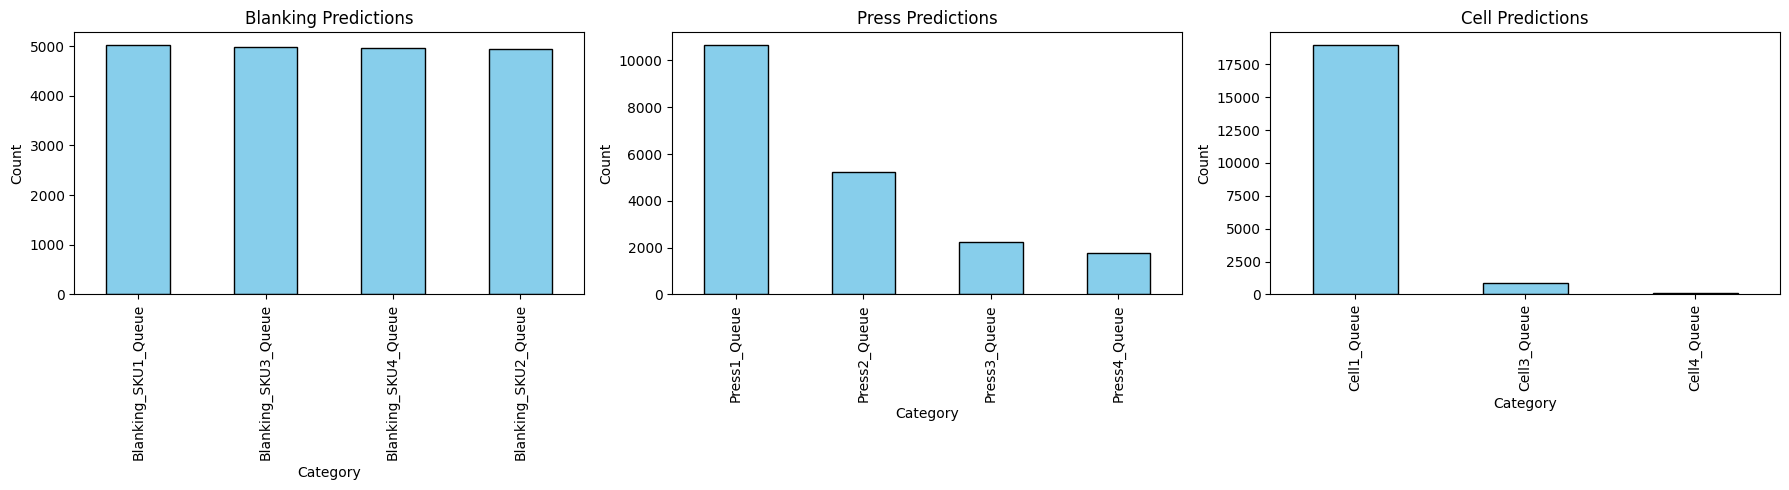

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("bottleneck_test_predictions.csv")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col, title in zip(
    axes, ["pred_Blanking", "pred_Press", "pred_Cell"], 
    ["Blanking Predictions", "Press Predictions", "Cell Predictions"]
):
    counts = df[col].value_counts()
    counts.plot(kind="bar", ax=ax, color="skyblue", edgecolor="black")
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.set_xlabel("Category")

plt.tight_layout()
plt.show()


pred_Blanking
Blanking_SKU1_Queue: 5026건, 25.3%
Blanking_SKU3_Queue: 4981건, 25.0%
Blanking_SKU4_Queue: 4954건, 24.9%
Blanking_SKU2_Queue: 4940건, 24.8%

pred_Press
Press1_Queue: 10666건, 53.6%
Press2_Queue: 5214건, 26.2%
Press3_Queue: 2235건, 11.2%
Press4_Queue: 1786건, 9.0%

pred_Cell
Cell1_Queue: 18975건, 95.3%
Cell3_Queue: 849건, 4.3%
Cell4_Queue: 77건, 0.4%


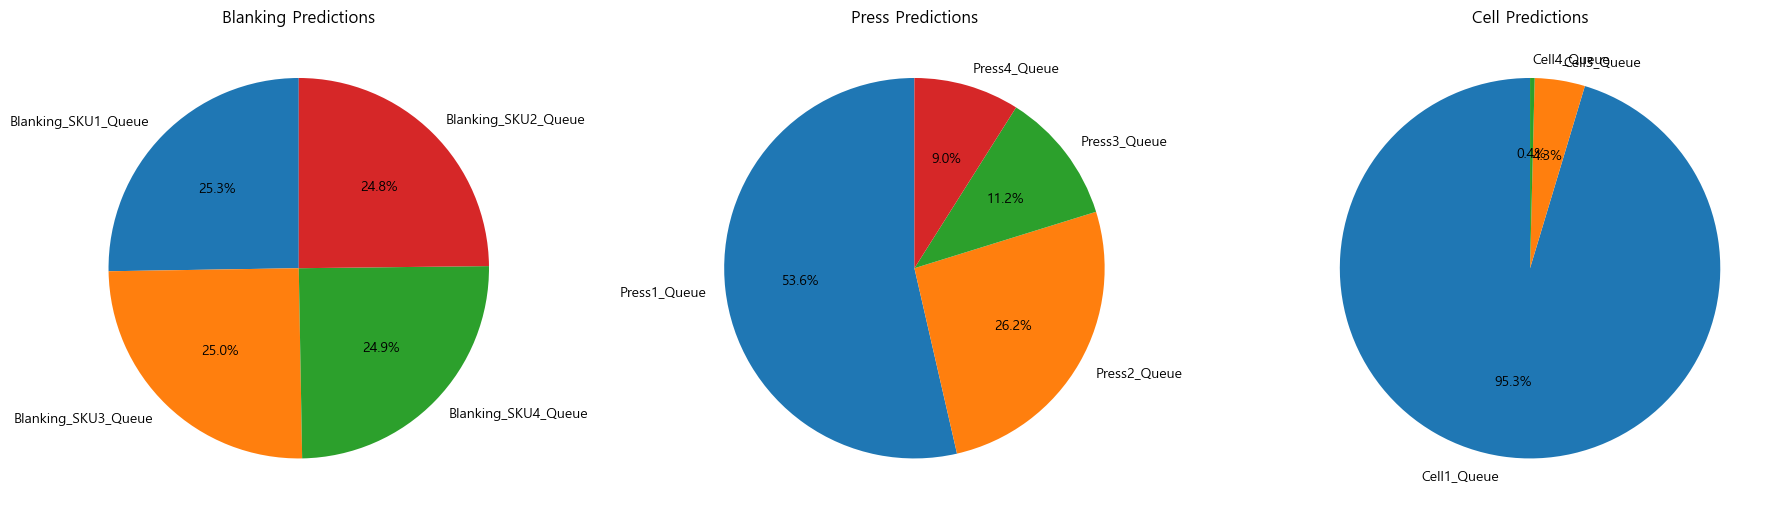

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, col, title in zip(
    axes, ["pred_Blanking", "pred_Press", "pred_Cell"], 
    ["Blanking Predictions", "Press Predictions", "Cell Predictions"]
):
    counts = df[col].value_counts()
    ratios = df[col].value_counts(normalize=True) * 100

    # 🔹 각 클래스별로 퍼센트 출력
    print(f"\n{col}")
    for cls, cnt in counts.items():
        print(f"{cls}: {cnt}건, {ratios[cls]:.1f}%")
        
    ax.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90)
    ax.set_title(title)

plt.tight_layout()
plt.show()

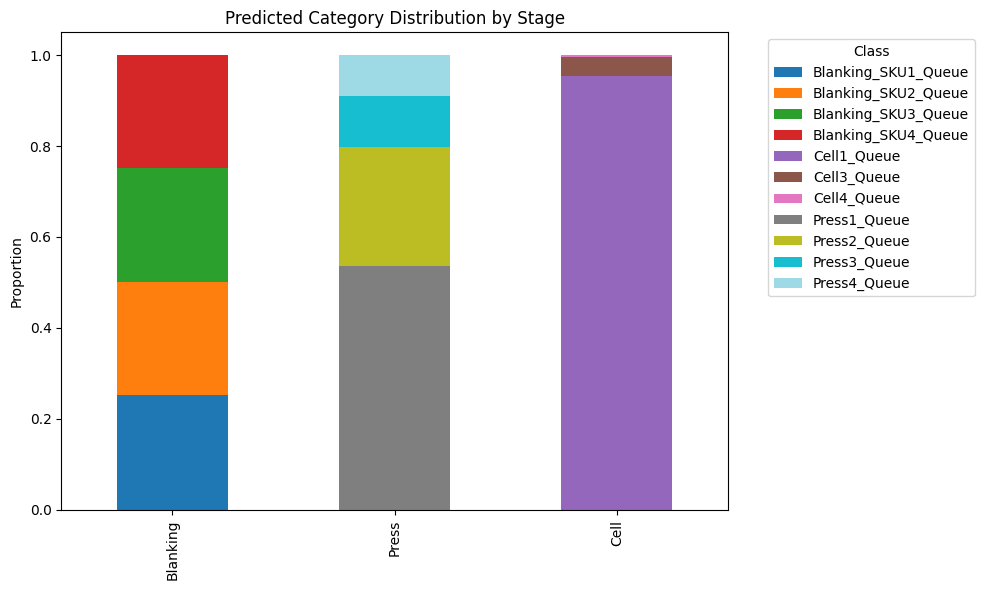

In [12]:
import seaborn as sns

# 공정별 분포를 합쳐서 하나의 테이블로
counts_df = pd.DataFrame({
    "Blanking": df["pred_Blanking"].value_counts(normalize=True),
    "Press": df["pred_Press"].value_counts(normalize=True),
    "Cell": df["pred_Cell"].value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T  # 전치 (행=공정, 열=클래스)

counts_df.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20")
plt.ylabel("Proportion")
plt.title("Predicted Category Distribution by Stage")
plt.legend(title="Class", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

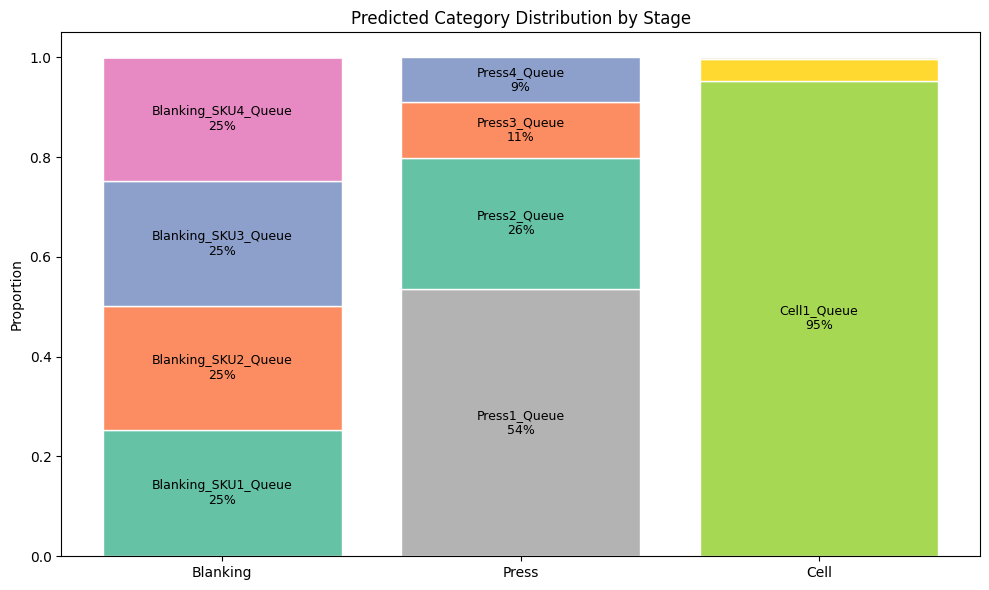

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----- 데이터 준비 -----
counts_df = pd.DataFrame({
    "Blanking": df["pred_Blanking"].value_counts(normalize=True),
    "Press": df["pred_Press"].value_counts(normalize=True),
    "Cell": df["pred_Cell"].value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T  # 행=공정, 열=클래스

# ----- 색상 팔레트 -----
palette = sns.color_palette("Set2", n_colors=counts_df.shape[1])

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(10,6))

bottoms = [0] * len(counts_df)
for i, col in enumerate(counts_df.columns):
    bars = ax.bar(
        counts_df.index,
        counts_df[col],
        bottom=bottoms,
        label=col,
        color=palette[i],
        edgecolor="white"
    )
    # 각 구간 위에 라벨 표시
    for bar in bars:
        height = bar.get_height()
        if height > 0.05:  # 작은 비율은 생략
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + height/2,
                f"{col}\n{height:.0%}",
                ha="center", va="center", fontsize=9, color="black"
            )
    bottoms = [b + v for b, v in zip(bottoms, counts_df[col])]

ax.set_ylabel("Proportion")
ax.set_title("Predicted Category Distribution by Stage")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [18]:
import matplotlib.pyplot as plt

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'   # Windows
plt.rcParams['axes.unicode_minus'] = False  

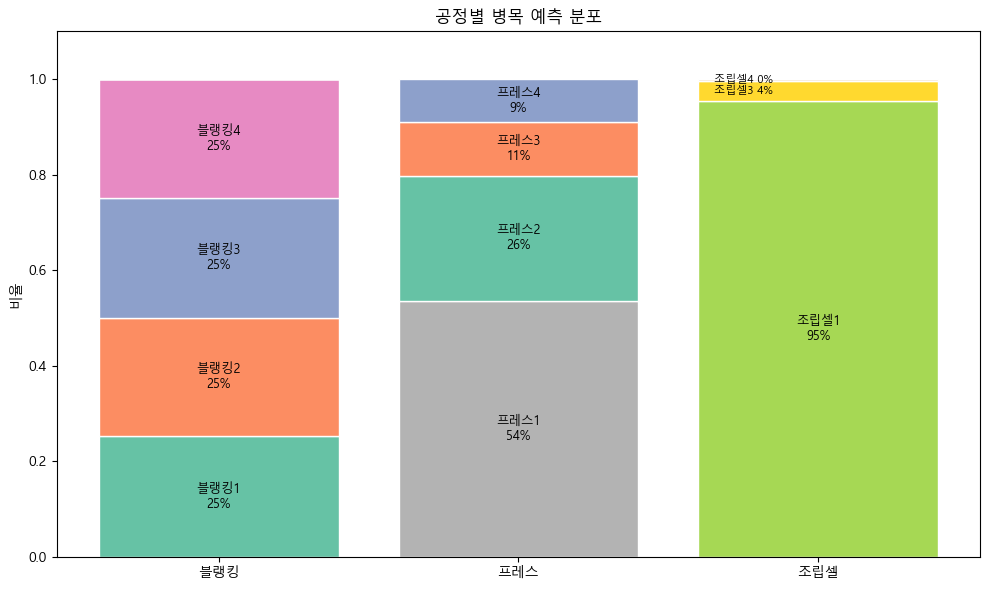

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_blanking = df["pred_Blanking"].replace(class_map)
df_press = df["pred_Press"].replace(class_map)
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Blanking": df_blanking.value_counts(normalize=True),
    "Press": df_press.value_counts(normalize=True),
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ----- 색상 팔레트 -----
palette = sns.color_palette("Set2", n_colors=counts_df.shape[1])

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(10,6))

bottoms = [0] * len(counts_df)
for i, col in enumerate(counts_df.columns):
    bars = ax.bar(
        counts_df.index,
        counts_df[col],
        bottom=bottoms,
        label=col,
        color=palette[i],
        edgecolor="white"
    )
    alt_side = True  # 좌/우 번갈아 쓰기
    for bar in bars:
        height = bar.get_height()
        if height > 0.05:
            # 큰 비율 → 중앙
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + height/2,
                f"{col}\n{height:.0%}",
                ha="center", va="center", fontsize=9, color="black"
            )
        elif height > 0:
            # 작은 비율 → 좌/우 교차 배치
            if alt_side:
                ax.text(
                    bar.get_x() + bar.get_width()/2 - 0.15,  # 막대 왼쪽
                    bar.get_y() + height/2,
                    f"{col} {height:.0%}",
                    ha="right", va="center", fontsize=8, color="black"
                )
            else:
                ax.text(
                    bar.get_x() + bar.get_width()/2 + 0.15,  # 막대 오른쪽
                    bar.get_y() + height/2,
                    f"{col} {height:.0%}",
                    ha="left", va="center", fontsize=8, color="black"
                )
            alt_side = not alt_side
    bottoms = [b + v for b, v in zip(bottoms, counts_df[col])]

ax.set_ylabel("비율")
ax.set_title("공정별 병목 예측 분포")
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

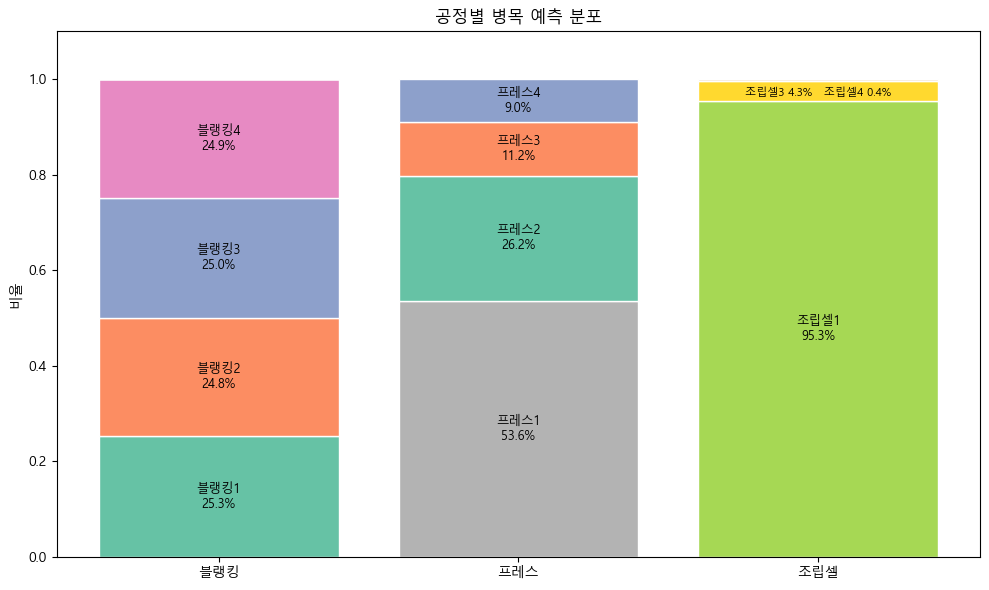

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_blanking = df["pred_Blanking"].replace(class_map)
df_press = df["pred_Press"].replace(class_map)
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Blanking": df_blanking.value_counts(normalize=True),
    "Press": df_press.value_counts(normalize=True),
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ----- 색상 팔레트 -----
palette = sns.color_palette("Set2", n_colors=counts_df.shape[1])

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(10,6))

bottoms = [0] * len(counts_df)
for i, col in enumerate(counts_df.columns):
    bars = ax.bar(
        counts_df.index,
        counts_df[col],
        bottom=bottoms,
        label=col,
        color=palette[i],
        edgecolor="white"
    )
    for bar in bars:
        height = bar.get_height()
        stage = counts_df.index[int(bar.get_x() + bar.get_width()/2)]

        if stage == "조립셀":
            # 조립셀1만 개별 표시 (중앙)
            if col == "조립셀1" and height > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    bar.get_y() + height/2,
                    f"{col}\n{height:.1%}",
                    ha="center", va="center", fontsize=9, color="black"
                )
            # 조립셀3/4는 따로 처리 (여기선 스킵)
            continue

        # ----- 블랭킹/프레스 기본 처리 -----
        if height > 0.05:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + height/2,
                f"{col}\n{height:.1%}",
                ha="center", va="center", fontsize=9, color="black"
            )
    bottoms = [b + v for b, v in zip(bottoms, counts_df[col])]

# ----- ✅ 조립셀3/4 묶어서 해당 위치 중앙에 표시 -----
cell_labels = []
cell_positions = []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col} {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text(
        x="조립셀",
        y=avg_y - 0.015,
        s="   ".join(cell_labels),
        ha="center", va="center", fontsize=8, color="black"
    )

# ----- 마무리 -----
ax.set_ylabel("비율")
ax.set_title("공정별 병목 예측 분포")
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

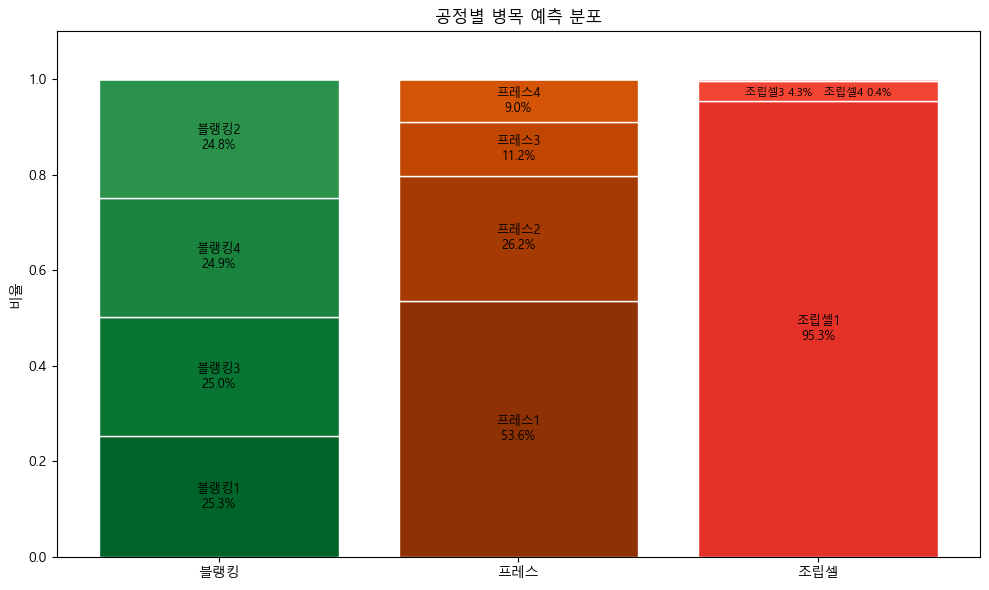

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_blanking = df["pred_Blanking"].replace(class_map)
df_press = df["pred_Press"].replace(class_map)
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Blanking": df_blanking.value_counts(normalize=True),
    "Press": df_press.value_counts(normalize=True),
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ----- 공정별 색 계열 -----
stage_cmaps = {
    "블랭킹": plt.cm.Greens,
    "프레스": plt.cm.YlOrBr,
    "조립셀": plt.cm.Reds,
}

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(10,6))

for stage in counts_df.index:
    row = counts_df.loc[stage]

    # 🔹 블랭킹, 프레스는 비율 큰 것부터 아래쪽 + 진한 색
    if stage in ["블랭킹", "프레스"]:
        row = row.sort_values(ascending=False)

    cmap = stage_cmaps[stage]
    n = len(row)
    colors = [cmap(x) for x in np.linspace(0.9, 0.3, n)]  # 진→연

    bottom = 0
    for (col, val), color in zip(row.items(), colors):
        bar = ax.bar(stage, val, bottom=bottom, color=color, edgecolor="white")

        if stage == "조립셀":
            # 조립셀1만 중앙 표시
            if col == "조립셀1" and val > 0:
                ax.text(bar[0].get_x()+bar[0].get_width()/2,
                        bottom+val/2,
                        f"{col}\n{val:.1%}",
                        ha="center", va="center", fontsize=9, color="black")
        else:
            # 블랭킹/프레스는 기본 처리
            if val > 0.05:
                ax.text(bar[0].get_x()+bar[0].get_width()/2,
                        bottom+val/2,
                        f"{col}\n{val:.1%}",
                        ha="center", va="center", fontsize=9, color="black")

        bottom += val

# ----- ✅ 조립셀3/4 묶어서 한 줄 표시 -----
cell_labels = []
cell_positions = []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col} {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y-0.015, "   ".join(cell_labels),
            ha="center", va="center", fontsize=8, color="black")

# ----- 마무리 -----
ax.set_ylabel("비율")
ax.set_title("공정별 병목 예측 분포")
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

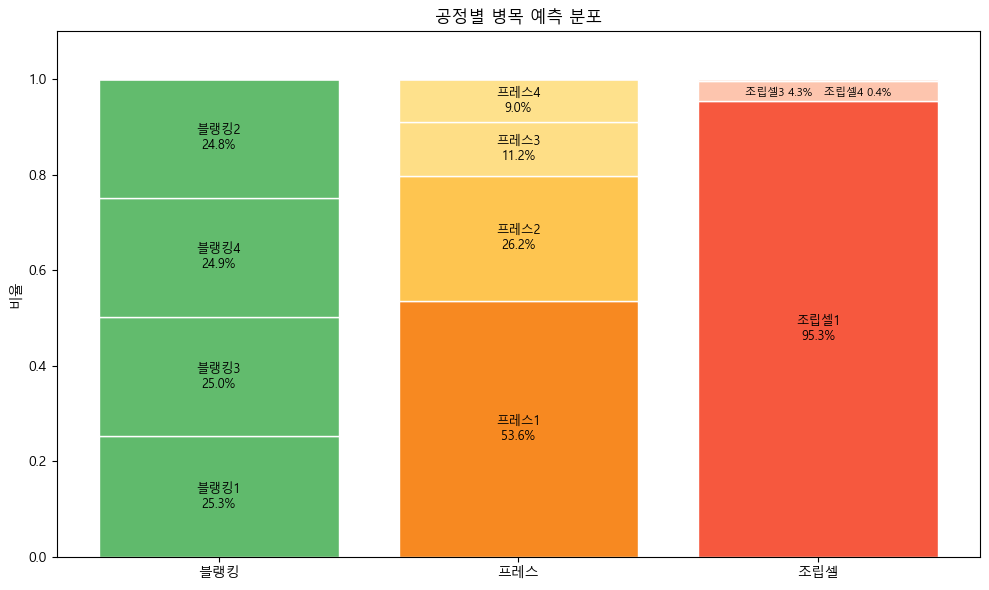

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_blanking = df["pred_Blanking"].replace(class_map)
df_press = df["pred_Press"].replace(class_map)
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Blanking": df_blanking.value_counts(normalize=True),
    "Press": df_press.value_counts(normalize=True),
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ----- 공정별 색 계열 -----
stage_cmaps = {
    "블랭킹": plt.cm.Greens,
    "프레스": plt.cm.YlOrBr,
    "조립셀": plt.cm.Reds,
}

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(10,6))

for stage in counts_df.index:
    row = counts_df.loc[stage]

    # 🔹 블랭킹, 프레스는 비율 큰 것부터 아래쪽
    if stage in ["블랭킹", "프레스"]:
        row = row.sort_values(ascending=False)

    cmap = stage_cmaps[stage]
    max_val = row.max()
    min_val = row.min() if row.min() > 0 else 0

    bottom = 0
    for col, val in row.items():
        if max_val == min_val:
            norm = 0.2
        else:
            norm = 0.2 + 0.35 * (val - min_val) / (max_val - min_val)  

        color = cmap(norm)

        bar = ax.bar(stage, val, bottom=bottom, color=color, edgecolor="white")

        if stage == "조립셀":
            if col == "조립셀1" and val > 0:
                ax.text(bar[0].get_x() + bar[0].get_width()/2,
                        bottom + val/2,
                        f"{col}\n{val:.1%}",
                        ha="center", va="center", fontsize=9, color="black")
        else:
            if val > 0.05:
                ax.text(bar[0].get_x() + bar[0].get_width()/2,
                        bottom + val/2,
                        f"{col}\n{val:.1%}",
                        ha="center", va="center", fontsize=9, color="black")

        bottom += val

# ----- ✅ 조립셀3/4 묶어서 한 줄 표시 -----
cell_labels = []
cell_positions = []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col} {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y - 0.015, "   ".join(cell_labels),
            ha="center", va="center", fontsize=8, color="black")

# ----- 마무리 -----
ax.set_ylabel("비율")
ax.set_title("공정별 병목 예측 분포")
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

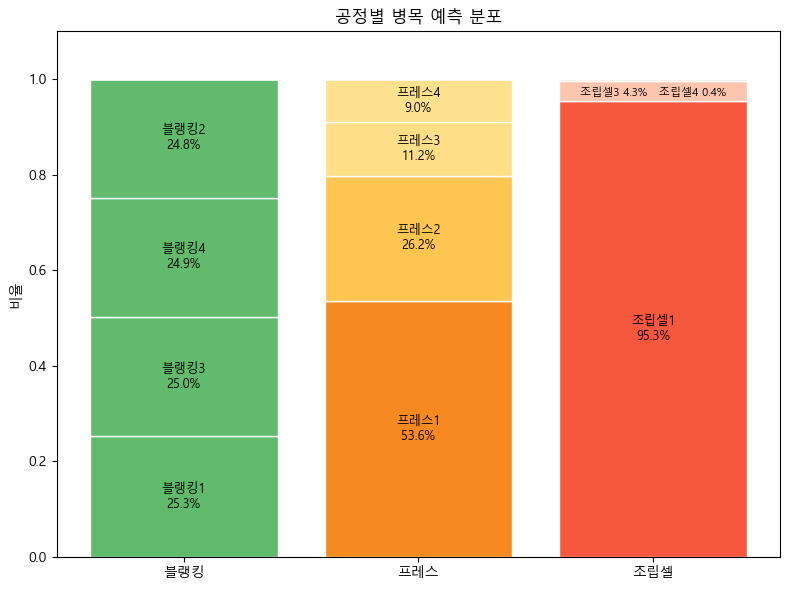

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_blanking = df["pred_Blanking"].replace(class_map)
df_press = df["pred_Press"].replace(class_map)
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Blanking": df_blanking.value_counts(normalize=True),
    "Press": df_press.value_counts(normalize=True),
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ----- 공정별 색 계열 -----
stage_cmaps = {
    "블랭킹": plt.cm.Greens,
    "프레스": plt.cm.YlOrBr,
    "조립셀": plt.cm.Reds,
}

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(8,6))

for stage in counts_df.index:
    row = counts_df.loc[stage]

    # 🔹 블랭킹, 프레스는 비율 큰 것부터 아래쪽
    if stage in ["블랭킹", "프레스"]:
        row = row.sort_values(ascending=False)

    cmap = stage_cmaps[stage]
    max_val = row.max()
    min_val = row.min() if row.min() > 0 else 0

    bottom = 0
    for col, val in row.items():
        if max_val == min_val:
            norm = 0.2
        else:
            norm = 0.2 + 0.35 * (val - min_val) / (max_val - min_val)  

        color = cmap(norm)

        bar = ax.bar(stage, val, bottom=bottom, color=color, edgecolor="white")

        if stage == "조립셀":
            if col == "조립셀1" and val > 0:
                ax.text(bar[0].get_x() + bar[0].get_width()/2,
                        bottom + val/2,
                        f"{col}\n{val:.1%}",
                        ha="center", va="center", fontsize=9, color="black")
        else:
            if val > 0.05:
                ax.text(bar[0].get_x() + bar[0].get_width()/2,
                        bottom + val/2,
                        f"{col}\n{val:.1%}",
                        ha="center", va="center", fontsize=9, color="black")

        bottom += val

# ----- ✅ 조립셀3/4 묶어서 한 줄 표시 -----
cell_labels = []
cell_positions = []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col} {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y - 0.015, "   ".join(cell_labels),
            ha="center", va="center", fontsize=8, color="black")

# ----- 마무리 -----
ax.set_ylabel("비율")
ax.set_title("공정별 병목 예측 분포")
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

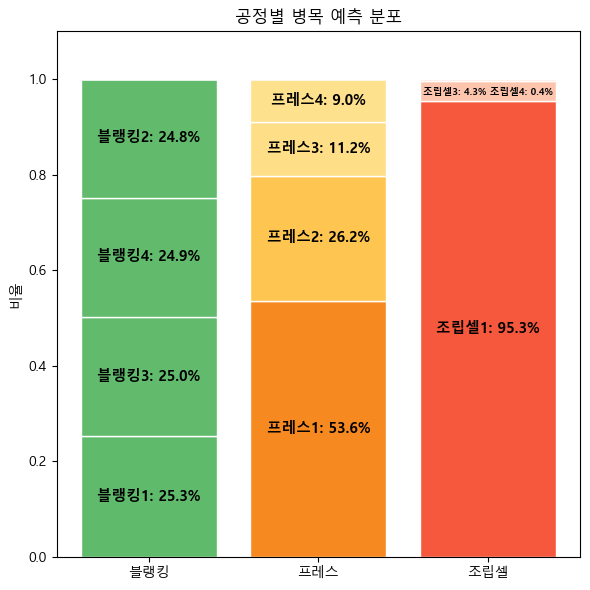

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_blanking = df["pred_Blanking"].replace(class_map)
df_press = df["pred_Press"].replace(class_map)
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Blanking": df_blanking.value_counts(normalize=True),
    "Press": df_press.value_counts(normalize=True),
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ----- 공정별 색 계열 -----
stage_cmaps = {
    "블랭킹": plt.cm.Greens,
    "프레스": plt.cm.YlOrBr,
    "조립셀": plt.cm.Reds,
}

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(6,6))

for stage in counts_df.index:
    row = counts_df.loc[stage]

    if stage in ["블랭킹", "프레스"]:
        row = row.sort_values(ascending=False)

    cmap = stage_cmaps[stage]
    max_val = row.max()
    min_val = row.min() if row.min() > 0 else 0

    bottom = 0
    for col, val in row.items():
        if max_val == min_val:
            norm = 0.2
        else:
            norm = 0.2 + 0.35 * (val - min_val) / (max_val - min_val)  

        color = cmap(norm)
        bar = ax.bar(stage, val, bottom=bottom, color=color, edgecolor="white")

        if stage == "조립셀":
            if col == "조립셀1" and val > 0:
                ax.text(
                    bar[0].get_x() + bar[0].get_width()/2,
                    bottom + val/2,
                    f"{col}: {val:.1%}",
                    ha="center", va="center", fontsize=10.5, fontweight="bold", color="black"
                )
        else:
            if val > 0.05:
                ax.text(
                    bar[0].get_x() + bar[0].get_width()/2,
                    bottom + val/2,
                    f"{col}: {val:.1%}",
                    ha="center", va="center", fontsize=10.5, fontweight="bold", color="black"
                )

        bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 (글자 크기는 그대로 8 유지) -----
cell_labels = []
cell_positions = []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text(
        "조립셀", avg_y - 0.015, " ".join(cell_labels),
        ha="center", va="center", fontsize=7, fontweight="bold", color="black"
    )

# ----- 마무리 -----
ax.set_ylabel("비율")
ax.set_title("공정별 병목 예측 분포")
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

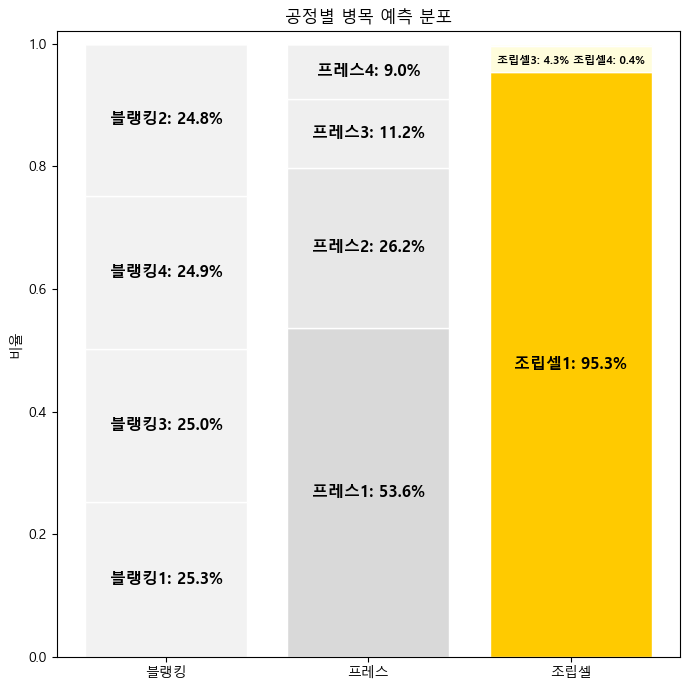

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_blanking = df["pred_Blanking"].replace(class_map)
df_press = df["pred_Press"].replace(class_map)
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Blanking": df_blanking.value_counts(normalize=True),
    "Press": df_press.value_counts(normalize=True),
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ----- 공정별 색 계열 -----
yellow_rgb = mcolors.to_rgb("#ffca00")
stage_cmaps = {
    "블랭킹": None,  # 블랭킹은 고정 연회색
    "프레스": mcolors.LinearSegmentedColormap.from_list(
        "grey_custom", [(0.96,0.96,0.96), (0.85,0.85,0.85)]),  # 밝은 회색 → 중간 회색
    "조립셀": mcolors.LinearSegmentedColormap.from_list(
        "cell_custom", [(1,1,0.9), yellow_rgb]),  # 연노랑 → 진노랑
}

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(7,7))

for stage in counts_df.index:
    row = counts_df.loc[stage]

    # 블랭킹·프레스는 큰 값 아래로
    if stage in ["블랭킹", "프레스"]:
        row = row.sort_values(ascending=False)

    cmap = stage_cmaps[stage]
    max_val = row.max()
    min_val = row.min() if row.min() > 0 else 0

    bottom = 0
    for col, val in row.items():
        # 색상 선택
        if stage == "블랭킹":
            color = "#f2f2f2"  # ✅ 고정 연회색
        else:
            if max_val == min_val:
                norm = 0.5
            else:
                norm = (val - min_val) / (max_val - min_val)
            color = cmap(norm)

        # 막대 그리기
        bar = ax.bar(stage, val, bottom=bottom, color=color, edgecolor="white")

        # 라벨 표시
        if stage == "조립셀":
            if col == "조립셀1" and val > 0:
                ax.text(
                    bar[0].get_x() + bar[0].get_width()/2,
                    bottom + val/2,
                    f"{col}: {val:.1%}",
                    ha="center", va="center", fontsize=11.5, fontweight="bold", color="black"
                )
        else:
            if val > 0.05:
                ax.text(
                    bar[0].get_x() + bar[0].get_width()/2,
                    bottom + val/2,
                    f"{col}: {val:.1%}",
                    ha="center", va="center", fontsize=11.5, fontweight="bold", color="black"
                )

        bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 (작은 글씨 유지) -----
cell_labels = []
cell_positions = []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text(
        "조립셀", avg_y - 0.015, " ".join(cell_labels),
        ha="center", va="center", fontsize=8, fontweight="bold", color="black"
    )

# ----- 마무리 -----
ax.set_ylabel("비율")
ax.set_title("공정별 병목 예측 분포")
ax.set_ylim(0, 1.02)

plt.tight_layout()
plt.show()

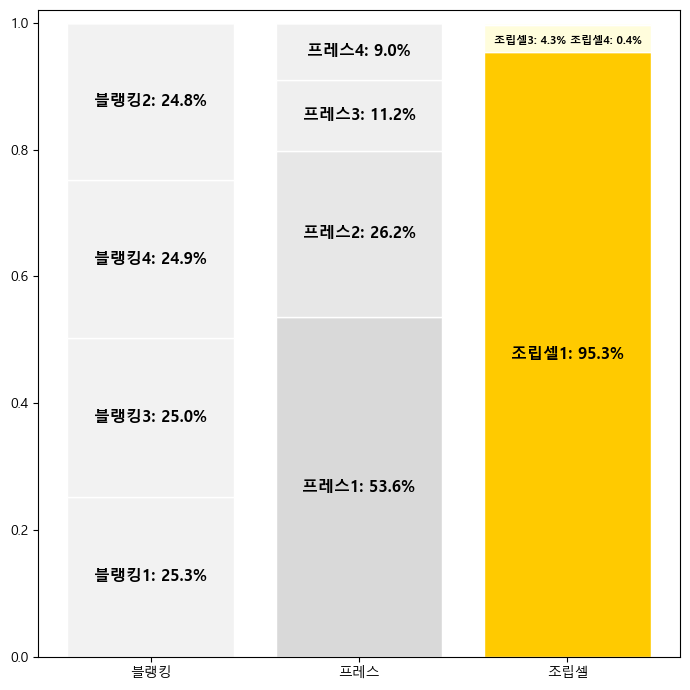

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_blanking = df["pred_Blanking"].replace(class_map)
df_press = df["pred_Press"].replace(class_map)
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Blanking": df_blanking.value_counts(normalize=True),
    "Press": df_press.value_counts(normalize=True),
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ----- 공정별 색 계열 -----
yellow_rgb = mcolors.to_rgb("#ffca00")
stage_cmaps = {
    "블랭킹": None,  # 블랭킹은 고정 연회색
    "프레스": mcolors.LinearSegmentedColormap.from_list(
        "grey_custom", [(0.96,0.96,0.96), (0.85,0.85,0.85)]),  # 밝은 회색 → 중간 회색
    "조립셀": mcolors.LinearSegmentedColormap.from_list(
        "cell_custom", [(1,1,0.9), yellow_rgb]),  # 연노랑 → 진노랑
}

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(7,7))

for stage in counts_df.index:
    row = counts_df.loc[stage]

    # 블랭킹·프레스는 큰 값 아래로
    if stage in ["블랭킹", "프레스"]:
        row = row.sort_values(ascending=False)

    cmap = stage_cmaps[stage]
    max_val = row.max()
    min_val = row.min() if row.min() > 0 else 0

    bottom = 0
    for col, val in row.items():
        # 색상 선택
        if stage == "블랭킹":
            color = "#f2f2f2"  # ✅ 고정 연회색
        else:
            if max_val == min_val:
                norm = 0.5
            else:
                norm = (val - min_val) / (max_val - min_val)
            color = cmap(norm)

        # 막대 그리기
        bar = ax.bar(stage, val, bottom=bottom, color=color, edgecolor="white")

        # 라벨 표시
        if stage == "조립셀":
            if col == "조립셀1" and val > 0:
                ax.text(
                    bar[0].get_x() + bar[0].get_width()/2,
                    bottom + val/2,
                    f"{col}: {val:.1%}",
                    ha="center", va="center", fontsize=11.5, fontweight="bold", color="black"
                )
        else:
            if val > 0.05:
                ax.text(
                    bar[0].get_x() + bar[0].get_width()/2,
                    bottom + val/2,
                    f"{col}: {val:.1%}",
                    ha="center", va="center", fontsize=11.5, fontweight="bold", color="black"
                )

        bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 (작은 글씨 유지) -----
cell_labels = []
cell_positions = []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text(
        "조립셀", avg_y - 0.015, " ".join(cell_labels),
        ha="center", va="center", fontsize=8, fontweight="bold", color="black"
    )

# ----- 마무리 -----
# ax.set_ylabel("비율")
# ax.set_title("공정별 병목 예측 분포")
ax.set_ylim(0, 1.02)

plt.tight_layout()
plt.show()

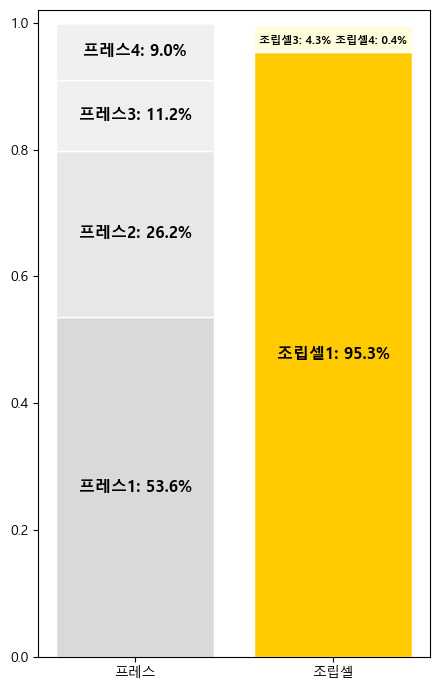

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_blanking = df["pred_Blanking"].replace(class_map)
df_press = df["pred_Press"].replace(class_map)
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Blanking": df_blanking.value_counts(normalize=True),
    "Press": df_press.value_counts(normalize=True),
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ✅ 블랭킹 제외
counts_df = counts_df.drop("블랭킹", errors="ignore")

# ----- 공정별 색 계열 -----
yellow_rgb = mcolors.to_rgb("#ffca00")
stage_cmaps = {
    "프레스": mcolors.LinearSegmentedColormap.from_list(
        "grey_custom", [(0.96,0.96,0.96), (0.85,0.85,0.85)]),
    "조립셀": mcolors.LinearSegmentedColormap.from_list(
        "cell_custom", [(1,1,0.9), yellow_rgb]),
}

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(4.5,7))

for stage in counts_df.index:
    row = counts_df.loc[stage]

    if stage == "프레스":
        row = row.sort_values(ascending=False)

    cmap = stage_cmaps[stage]
    max_val = row.max()
    min_val = row.min() if row.min() > 0 else 0

    bottom = 0
    for col, val in row.items():
        if max_val == min_val:
            norm = 0.5
        else:
            norm = (val - min_val) / (max_val - min_val)
        color = cmap(norm)

        bar = ax.bar(stage, val, bottom=bottom, color=color, edgecolor="white")

        if stage == "조립셀":
            if col == "조립셀1" and val > 0:
                ax.text(bar[0].get_x()+bar[0].get_width()/2,
                        bottom+val/2,
                        f"{col}: {val:.1%}",
                        ha="center", va="center", fontsize=11.5,
                        fontweight="bold", color="black")
        else:
            if val > 0.05:
                ax.text(bar[0].get_x()+bar[0].get_width()/2,
                        bottom+val/2,
                        f"{col}: {val:.1%}",
                        ha="center", va="center", fontsize=11.5,
                        fontweight="bold", color="black")

        bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 -----
cell_labels, cell_positions = [], []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y-0.015, " ".join(cell_labels),
            ha="center", va="center", fontsize=8,
            fontweight="bold", color="black")

# ----- 마무리 -----
ax.set_ylim(0, 1.02)
plt.tight_layout()
plt.show()

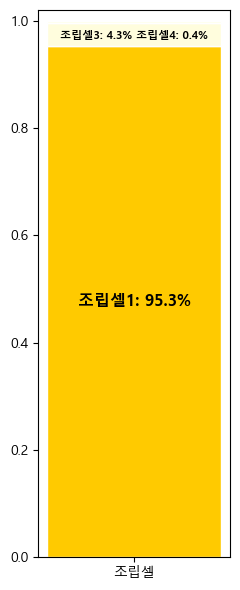

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ✅ 조립셀만 남기기
counts_df = counts_df.loc[["조립셀"]]

# ----- 색 계열 (연노랑 → 진노랑) -----
yellow_rgb = mcolors.to_rgb("#ffca00")
cmap = mcolors.LinearSegmentedColormap.from_list(
    "cell_custom", [(1,1,0.9), yellow_rgb]
)

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(2.5,6))

row = counts_df.loc["조립셀"]
max_val = row.max()
min_val = row.min() if row.min() > 0 else 0

bottom = 0
for col, val in row.items():
    if max_val == min_val:
        norm = 0.5
    else:
        norm = (val - min_val) / (max_val - min_val)
    color = cmap(norm)

    bar = ax.bar("조립셀", val, bottom=bottom, color=color, edgecolor="white")

    if col == "조립셀1" and val > 0:
        ax.text(bar[0].get_x()+bar[0].get_width()/2,
                bottom+val/2,
                f"{col}: {val:.1%}",
                ha="center", va="center", fontsize=11.5,
                fontweight="bold", color="black")

    bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 -----
cell_labels, cell_positions = [], []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y-0.015, " ".join(cell_labels),
            ha="center", va="center", fontsize=8,
            fontweight="bold", color="black")

# ----- 마무리 -----
ax.set_ylim(0, 1.02)
plt.tight_layout()
plt.show()

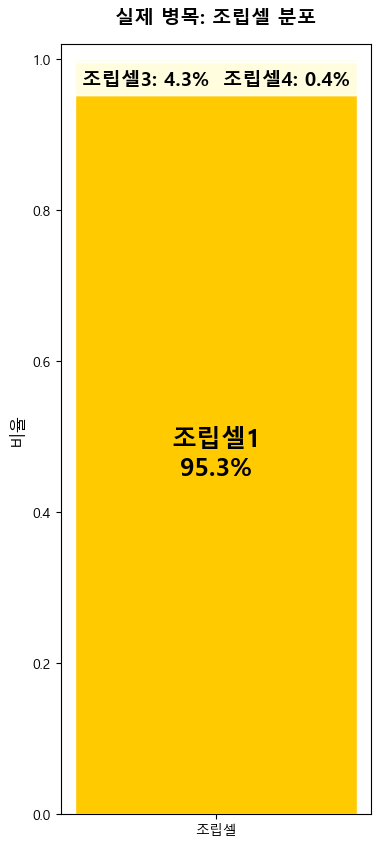

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ✅ 조립셀만 남기기
counts_df = counts_df.loc[["조립셀"]]

# ----- 색 계열 (연노랑 → 진노랑) -----
yellow_rgb = mcolors.to_rgb("#ffca00")
cmap = mcolors.LinearSegmentedColormap.from_list(
    "cell_custom", [(1,1,0.9), yellow_rgb]  # 연노랑 → 진노랑
)

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(4,10), dpi=100)  # ✅ 크기와 해상도 확장

row = counts_df.loc["조립셀"]
max_val = row.max()
min_val = row.min() if row.min() > 0 else 0

bottom = 0
for col, val in row.items():
    if max_val == min_val:
        norm = 0.5
    else:
        norm = (val - min_val) / (max_val - min_val)
    color = cmap(norm)

    bar = ax.bar("조립셀", val, bottom=bottom, color=color, edgecolor="white")

    if col == "조립셀1" and val > 0:
        ax.text(bar[0].get_x()+bar[0].get_width()/2,
                bottom+val/2,
                f"{col}\n{val:.1%}",
                ha="center", va="center", fontsize=18,
                fontweight="bold", color="black")

    bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 -----
cell_labels, cell_positions = [], []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y-0.015, "  ".join(cell_labels),
            ha="center", va="center", fontsize=14,
            fontweight="bold", color="black")

# ----- 마무리 -----
ax.set_ylim(0, 1.02)
ax.set_ylabel("비율", fontsize=12)
ax.set_title("실제 병목: 조립셀 분포", fontsize=14, fontweight="bold", pad=15)

plt.show()

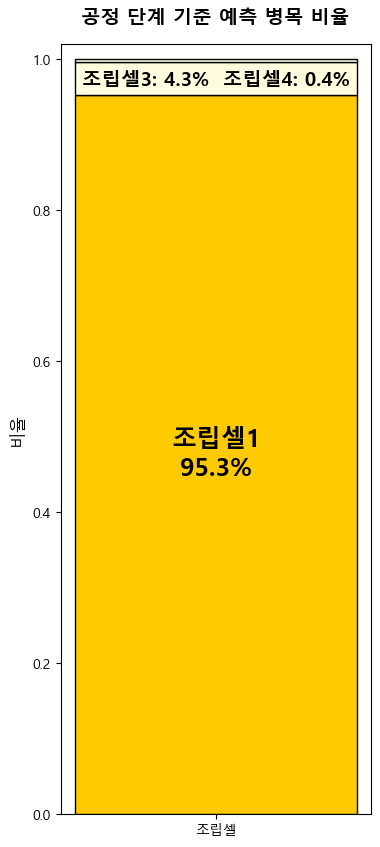

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ✅ 조립셀만 남기기
counts_df = counts_df.loc[["조립셀"]]

# ----- 색 계열 (연노랑 → 진노랑) -----
yellow_rgb = mcolors.to_rgb("#ffca00")
cmap = mcolors.LinearSegmentedColormap.from_list(
    "cell_custom", [(1,1,0.9), yellow_rgb]  # 연노랑 → 진노랑
)

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(4,10), dpi=100)  # ✅ 크기와 해상도 확장

row = counts_df.loc["조립셀"]
max_val = row.max()
min_val = row.min() if row.min() > 0 else 0

bottom = 0
for col, val in row.items():
    if max_val == min_val:
        norm = 0.5
    else:
        norm = (val - min_val) / (max_val - min_val)
    color = cmap(norm)

    bar = ax.bar("조립셀", val, bottom=bottom, color=color, edgecolor="black")

    if col == "조립셀1" and val > 0:
        ax.text(bar[0].get_x()+bar[0].get_width()/2,
                bottom+val/2,
                f"{col}\n{val:.1%}",
                ha="center", va="center", fontsize=18,
                fontweight="bold", color="black")

    bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 -----
cell_labels, cell_positions = [], []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y-0.015, "  ".join(cell_labels),
            ha="center", va="center", fontsize=14,
            fontweight="bold", color="black")

# ----- 마무리 -----
ax.set_ylim(0, 1.02)
ax.set_ylabel("비율", fontsize=12)
ax.set_title("공정 단계 기준 예측 병목 비율", fontsize=14, fontweight="bold", pad=15)

plt.show()

C:\Users\KDT6\AppData\Local\Temp\ipykernel_39896\121761456.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontweight="bold")
C:\Users\KDT6\AppData\Local\Temp\ipykernel_39896\121761456.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}" for tick in ax.get_yticks()],


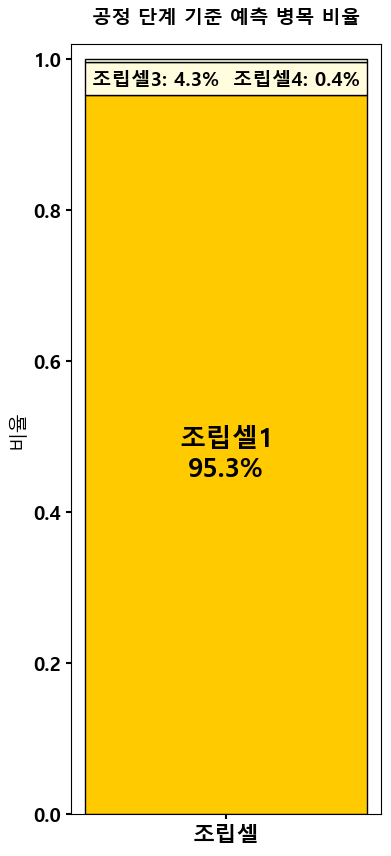

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ✅ 조립셀만 남기기
counts_df = counts_df.loc[["조립셀"]]

# ----- 색 계열 (연노랑 → 진노랑) -----
yellow_rgb = mcolors.to_rgb("#ffca00")
cmap = mcolors.LinearSegmentedColormap.from_list(
    "cell_custom", [(1,1,0.9), yellow_rgb]  # 연노랑 → 진노랑
)

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(4,10), dpi=100)  # ✅ 크기와 해상도 확장

row = counts_df.loc["조립셀"]
max_val = row.max()
min_val = row.min() if row.min() > 0 else 0

bottom = 0
for col, val in row.items():
    if max_val == min_val:
        norm = 0.5
    else:
        norm = (val - min_val) / (max_val - min_val)
    color = cmap(norm)

    bar = ax.bar("조립셀", val, bottom=bottom, color=color, edgecolor="black")

    if col == "조립셀1" and val > 0:
        ax.text(bar[0].get_x()+bar[0].get_width()/2,
                bottom+val/2,
                f"{col}\n{val:.1%}",
                ha="center", va="center", fontsize=19,
                fontweight="bold", color="black")

    bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 -----
cell_labels, cell_positions = [], []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y-0.015, "  ".join(cell_labels),
            ha="center", va="center", fontsize=14,
            fontweight="bold", color="black")

# ----- 마무리 -----
ax.set_ylim(0, 1.02)
ax.set_ylabel("비율", fontsize=14)
ax.set_title("공정 단계 기준 예측 병목 비율", fontsize=14, fontweight="bold", pad=15)

# ✅ x축, y축 눈금 폰트 크기 키우기
ax.tick_params(axis="x", labelsize=16, width=1.5)
ax.tick_params(axis="y", labelsize=14, width=1.5)

# ✅ x축 라벨 직접 조정 (굵게)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontweight="bold")

# ✅ y축 라벨 직접 조정 (굵게)
# ax.set_yticklabels([f"{int(tick*100)}%" for tick in ax.get_yticks()],
#                    fontsize=14, fontweight="bold")
ax.set_yticklabels([f"{tick:.1f}" for tick in ax.get_yticks()],
                   fontsize=14, fontweight="bold")

plt.show()

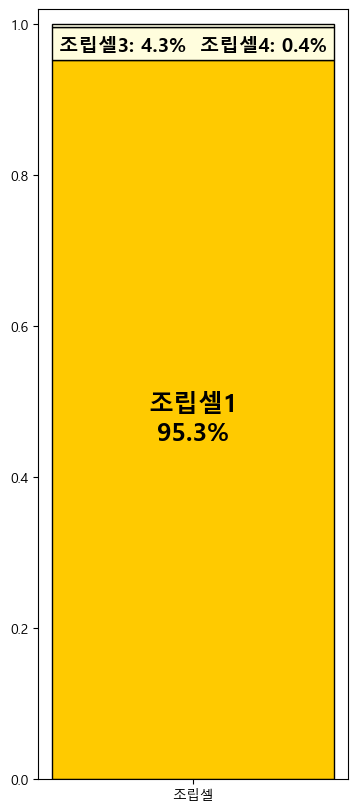

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ✅ 조립셀만 남기기
counts_df = counts_df.loc[["조립셀"]]

# ----- 색 계열 (연노랑 → 진노랑) -----
yellow_rgb = mcolors.to_rgb("#ffca00")
cmap = mcolors.LinearSegmentedColormap.from_list(
    "cell_custom", [(1,1,0.9), yellow_rgb]  # 연노랑 → 진노랑
)

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(4,10), dpi=100)  # ✅ 크기와 해상도 확장

row = counts_df.loc["조립셀"]
max_val = row.max()
min_val = row.min() if row.min() > 0 else 0

bottom = 0
for col, val in row.items():
    if max_val == min_val:
        norm = 0.5
    else:
        norm = (val - min_val) / (max_val - min_val)
    color = cmap(norm)

    bar = ax.bar("조립셀", val, bottom=bottom, color=color, edgecolor="black")

    if col == "조립셀1" and val > 0:
        ax.text(bar[0].get_x()+bar[0].get_width()/2,
                bottom+val/2,
                f"{col}\n{val:.1%}",
                ha="center", va="center", fontsize=18,
                fontweight="bold", color="black")

    bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 -----
cell_labels, cell_positions = [], []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y-0.015, "  ".join(cell_labels),
            ha="center", va="center", fontsize=14,
            fontweight="bold", color="black")

# ----- 마무리 -----
ax.set_ylim(0, 1.02)
# ax.set_ylabel("비율", fontsize=12)
# ax.set_title("공정 단계 기준 예측 병목 비율", fontsize=14, fontweight="bold", pad=15)

plt.show()

C:\Users\KDT6\AppData\Local\Temp\ipykernel_39896\3413109118.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontweight="bold")
C:\Users\KDT6\AppData\Local\Temp\ipykernel_39896\3413109118.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}" for tick in ax.get_yticks()],


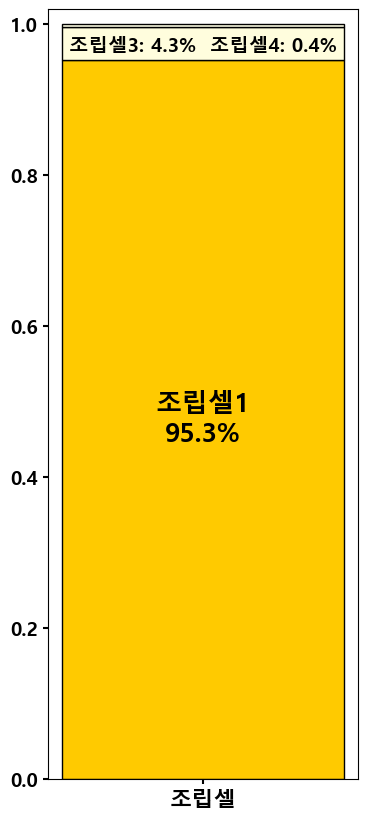

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ✅ 조립셀만 남기기
counts_df = counts_df.loc[["조립셀"]]

# ----- 색 계열 (연노랑 → 진노랑) -----
yellow_rgb = mcolors.to_rgb("#ffca00")
cmap = mcolors.LinearSegmentedColormap.from_list(
    "cell_custom", [(1,1,0.9), yellow_rgb]  # 연노랑 → 진노랑
)

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(4,10), dpi=100)  # ✅ 크기와 해상도 확장

row = counts_df.loc["조립셀"]
max_val = row.max()
min_val = row.min() if row.min() > 0 else 0

bottom = 0
for col, val in row.items():
    if max_val == min_val:
        norm = 0.5
    else:
        norm = (val - min_val) / (max_val - min_val)
    color = cmap(norm)

    bar = ax.bar("조립셀", val, bottom=bottom, color=color, edgecolor="black")

    if col == "조립셀1" and val > 0:
        ax.text(bar[0].get_x()+bar[0].get_width()/2,
                bottom+val/2,
                f"{col}\n{val:.1%}",
                ha="center", va="center", fontsize=19,
                fontweight="bold", color="black")

    bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 -----
cell_labels, cell_positions = [], []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y-0.015, "  ".join(cell_labels),
            ha="center", va="center", fontsize=14,
            fontweight="bold", color="black")

# ----- 마무리 -----
ax.set_ylim(0, 1.02)

# ✅ x축, y축 눈금 폰트 크기 키우기
ax.tick_params(axis="x", labelsize=16, width=1.5)
ax.tick_params(axis="y", labelsize=14, width=1.5)

# ✅ x축 라벨 직접 조정 (굵게)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, fontweight="bold")

# ✅ y축 라벨 직접 조정 (굵게)
# ax.set_yticklabels([f"{int(tick*100)}%" for tick in ax.get_yticks()],
#                    fontsize=14, fontweight="bold")
ax.set_yticklabels([f"{tick:.1f}" for tick in ax.get_yticks()],
                   fontsize=14, fontweight="bold")

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
stage_map = {"Blanking": "블랭킹", "Press": "프레스", "Cell": "조립셀"}

class_map = {
    "Blanking_SKU1_Queue": "블랭킹1",
    "Blanking_SKU2_Queue": "블랭킹2",
    "Blanking_SKU3_Queue": "블랭킹3",
    "Blanking_SKU4_Queue": "블랭킹4",
    "Press1_Queue": "프레스1",
    "Press2_Queue": "프레스2",
    "Press3_Queue": "프레스3",
    "Press4_Queue": "프레스4",
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_cell = df["pred_Cell"].replace(class_map)

counts_df = pd.DataFrame({
    "Cell": df_cell.value_counts(normalize=True)
}).fillna(0)

counts_df = counts_df.T
counts_df.index = counts_df.index.map(stage_map.get)
counts_df.rename(columns=class_map, inplace=True)

# ✅ 조립셀만 남기기
counts_df = counts_df.loc[["조립셀"]]

# ----- 색 계열 (연노랑 → 진노랑) -----
yellow_rgb = mcolors.to_rgb("#ffca00")
cmap = mcolors.LinearSegmentedColormap.from_list(
    "cell_custom", [(1,1,0.9), yellow_rgb]
)

# ----- 시각화 -----
fig, ax = plt.subplots(figsize=(2.5,6))

row = counts_df.loc["조립셀"]
max_val = row.max()
min_val = row.min() if row.min() > 0 else 0

bottom = 0
for col, val in row.items():
    if max_val == min_val:
        norm = 0.5
    else:
        norm = (val - min_val) / (max_val - min_val)
    color = cmap(norm)

    bar = ax.bar("조립셀", val, bottom=bottom, color=color, edgecolor="white")

    if col == "조립셀1" and val > 0:
        ax.text(bar[0].get_x()+bar[0].get_width()/2,
                bottom+val/2,
                f"{col}: {val:.1%}",
                ha="center", va="center", fontsize=11.5,
                fontweight="bold", color="black")

    bottom += val

# ----- ✅ 조립셀3/4 묶어서 표시 -----
cell_labels, cell_positions = [], []
cumulative = 0
for col in counts_df.columns:
    val = counts_df.loc["조립셀", col]
    if val > 0:
        if col in ["조립셀3", "조립셀4"]:
            cell_labels.append(f"{col}: {val:.1%}")
            y_pos = cumulative + val/2
            cell_positions.append(y_pos)
        cumulative += val

if cell_labels:
    avg_y = sum(cell_positions) / len(cell_positions)
    ax.text("조립셀", avg_y-0.015, " ".join(cell_labels),
            ha="center", va="center", fontsize=8,
            fontweight="bold", color="black")

# ----- 마무리 -----
ax.set_ylim(0, 1.02)
plt.tight_layout()
plt.show()

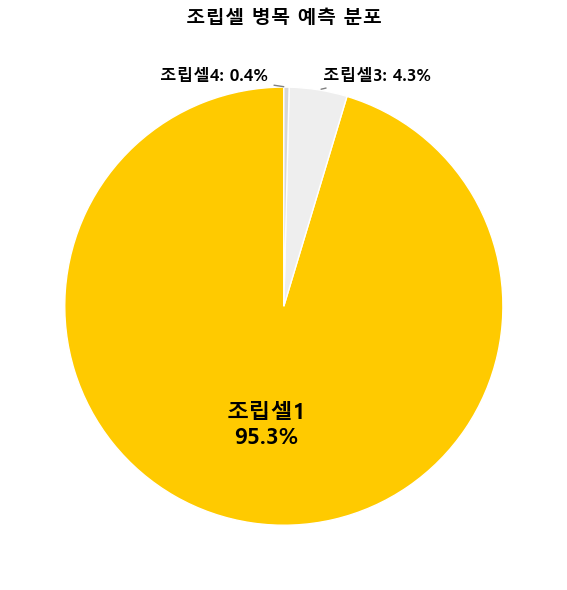

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----- 이름 매핑 -----
class_map = {
    "Cell1_Queue": "조립셀1",
    "Cell2_Queue": "조립셀2",
    "Cell3_Queue": "조립셀3",
    "Cell4_Queue": "조립셀4",
}

# ----- 데이터 준비 -----
df_cell = df["pred_Cell"].replace(class_map)
counts = df_cell.value_counts(normalize=True)

# ----- 색상 지정 -----
colors = []
for label in counts.index:
    if label == "조립셀1":
        colors.append("#ffca00")  # 진노랑
    elif label == "조립셀3":
        colors.append("#eeeeee")  # 연한 회색
    elif label == "조립셀4":
        colors.append("#d6d6d6")  # 아주 연한 회색
    else:
        colors.append("#f5f5f5")

# ----- 파이차트 -----
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts = ax.pie(
    counts,
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor":"white"}
)

# ----- 라벨 표시 -----
for wedge, (label, val) in zip(wedges, counts.items()):
    ang = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    if label == "조립셀1":
        # ✅ 원 내부 중앙
        ax.text(
            0.55 * x, 0.55 * y,
            f"{label}\n{val:.1%}",
            ha="center", va="center",
            fontsize=16, fontweight="bold", color="black"
        )

    elif label == "조립셀4":
        # ✅ 조립셀4 → 원 위쪽 바깥, 왼쪽
        ax.annotate(
            f"{label}: {val:.1%}",
            xy=(x, y), xytext=(-0.07, 1.05),  # 살짝 원 위로 올려 배치
            arrowprops=dict(arrowstyle="-", color="gray"),
            ha="right", va="center",
            fontsize=12, fontweight="bold"
        )

    elif label == "조립셀3":
        # ✅ 조립셀3 → 원 위쪽 바깥, 오른쪽
        ax.annotate(
            f"{label}: {val:.1%}",
            xy=(x, y), xytext=(0.18, 1.05),  # 같은 y선상, 더 오른쪽
            arrowprops=dict(arrowstyle="-", color="gray"),
            ha="left", va="center",
            fontsize=12, fontweight="bold"
        )

ax.set_title("조립셀 병목 예측 분포", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()